# Install Packages

In [31]:
!pip install pydot

In [33]:
import pandas as pd
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
import numpy as np
from typing import Union
import numpy as np
import pydot

# Quick Start Guide for BOM Analysis

In [ ]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, leaf_vs_root_factor = 0.5):

    '''
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    Based on Joel's answer at https://stackoverflow.com/a/29597209/2966723,
    but with some modifications.  

    We include this because it may be useful for plotting transmission trees,
    and there is currently no networkx equivalent (though it may be coming soon).
    
    There are two basic approaches we think of to allocate the horizontal 
    location of a node.  
    
    - Top down: we allocate horizontal space to a node.  Then its ``k`` 
      descendants split up that horizontal space equally.  This tends to result
      in overlapping nodes when some have many descendants.
    - Bottom up: we allocate horizontal space to each leaf node.  A node at a 
      higher level gets the entire space allocated to its descendant leaves.
      Based on this, leaf nodes at higher levels get the same space as leaf
      nodes very deep in the tree.  
      
    We use use both of these approaches simultaneously with ``leaf_vs_root_factor`` 
    determining how much of the horizontal space is based on the bottom up 
    or top down approaches.  ``0`` gives pure bottom up, while 1 gives pure top
    down.   
    
    
    :Arguments: 
    
    **G** the graph (must be a tree)

    **root** the root node of the tree 
    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be 
      just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    **width** horizontal space allocated for this branch - avoids overlap with other branches

    **vert_gap** gap between levels of hierarchy

    **vert_loc** vertical location of root
    
    **leaf_vs_root_factor**

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, leftmost, width, leafdx = 0.2, vert_gap = 0.2, vert_loc = 0, 
                    xcenter = 0.5, rootpos = None, 
                    leafpos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if rootpos is None:
            rootpos = {root:(xcenter,vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = list(G.neighbors(root))
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            rootdx = width/len(children)
            nextx = xcenter - width/2 - rootdx/2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(G,child, leftmost+leaf_count*leafdx, 
                                    width=rootdx, leafdx=leafdx,
                                    vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, 
                                    xcenter=nextx, rootpos=rootpos, leafpos=leafpos, parent = root)
                leaf_count += newleaves

            leftmostchild = min((x for x,y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x,y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild+rightmostchild)/2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root]  = (leftmost, vert_loc)
        return rootpos, leafpos, leaf_count

    xcenter = width/2.
    if isinstance(G, nx.DiGraph):
        leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==0])
    elif isinstance(G, nx.Graph):
        leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==1 and node != root])
    rootpos, leafpos, leaf_count = _hierarchy_pos(G, root, 0, width, 
                                                    leafdx=width*1./leafcount, 
                                                    vert_gap=vert_gap, 
                                                    vert_loc = vert_loc, 
                                                    xcenter = xcenter)
    pos = {}
    for node in rootpos:
        pos[node] = (leaf_vs_root_factor*leafpos[node][0] + (1-leaf_vs_root_factor)*rootpos[node][0], leafpos[node][1]) 
    xmax = max(x for x,y in pos.values())
    for node in pos:
        pos[node]= (pos[node][0]*width/xmax, pos[node][1])
    return pos

## Step 1: Get Data
This would probably be a sql query converted to a dataframe. But, for the purpose of this notebook, I will manually create a simple BOM

In [100]:
def generate_random_bom(nodes: int = 20, min_leadtime: int = 1, max_leadtime: int = 10):
    """
    Creates a random BOM in the form of a networkx directed graph (DiGraph). Each parent is guaranteed to have at least 2 children.

    Args:
    - nodes: int
    """
    if nodes < 1:
        raise ValueError('Error: Nodes must be greater than zero.')
    if min_leadtime < 0:
        raise ValueError('Error: Minimum leadtime cannot be negative.')
    if max_leadtime < min_leadtime:
        raise ValueError('Error: Maximum leadtime cannot be less than minimum leadtime.')

    bom = nx.DiGraph()
    bom.add_node('P0')

    node = 1
    while node <= nodes:
        existing_parents = list(bom.nodes)
        random_parent = random.choice(list(bom.nodes))
        curr_children_count = len(list(bom.successors(random_parent)))
        if curr_children_count < 1:
            new_node = f'P{node}'
            bom.add_node(new_node)
            bom.add_edge(random_parent, new_node, leadtime=random.randint(min_leadtime, max_leadtime))
            node += 1
        
        new_node = f'P{node}'
        bom.add_node(new_node)
        bom.add_edge(random_parent, new_node, leadtime=random.randint(min_leadtime, max_leadtime))
        node += 1
    bom.add_node('Complete')
    bom.add_edge('Complete', 'P0', leadtime=random.randint(min_leadtime, max_leadtime))

    return bom


In [107]:
random_bom = generate_random_bom(50)
longest_path = nx.dag_longest_path(random_bom)
longest_path_length = nx.dag_longest_path_length(random_bom, weight='leadtime')
print(f'Cold start lead time is {longest_path_length} days.')
' -> '.join(longest_path)

Cold start lead time is 51 days.


'Complete -> P0 -> P2 -> P5 -> P17 -> P27 -> P37 -> P43'

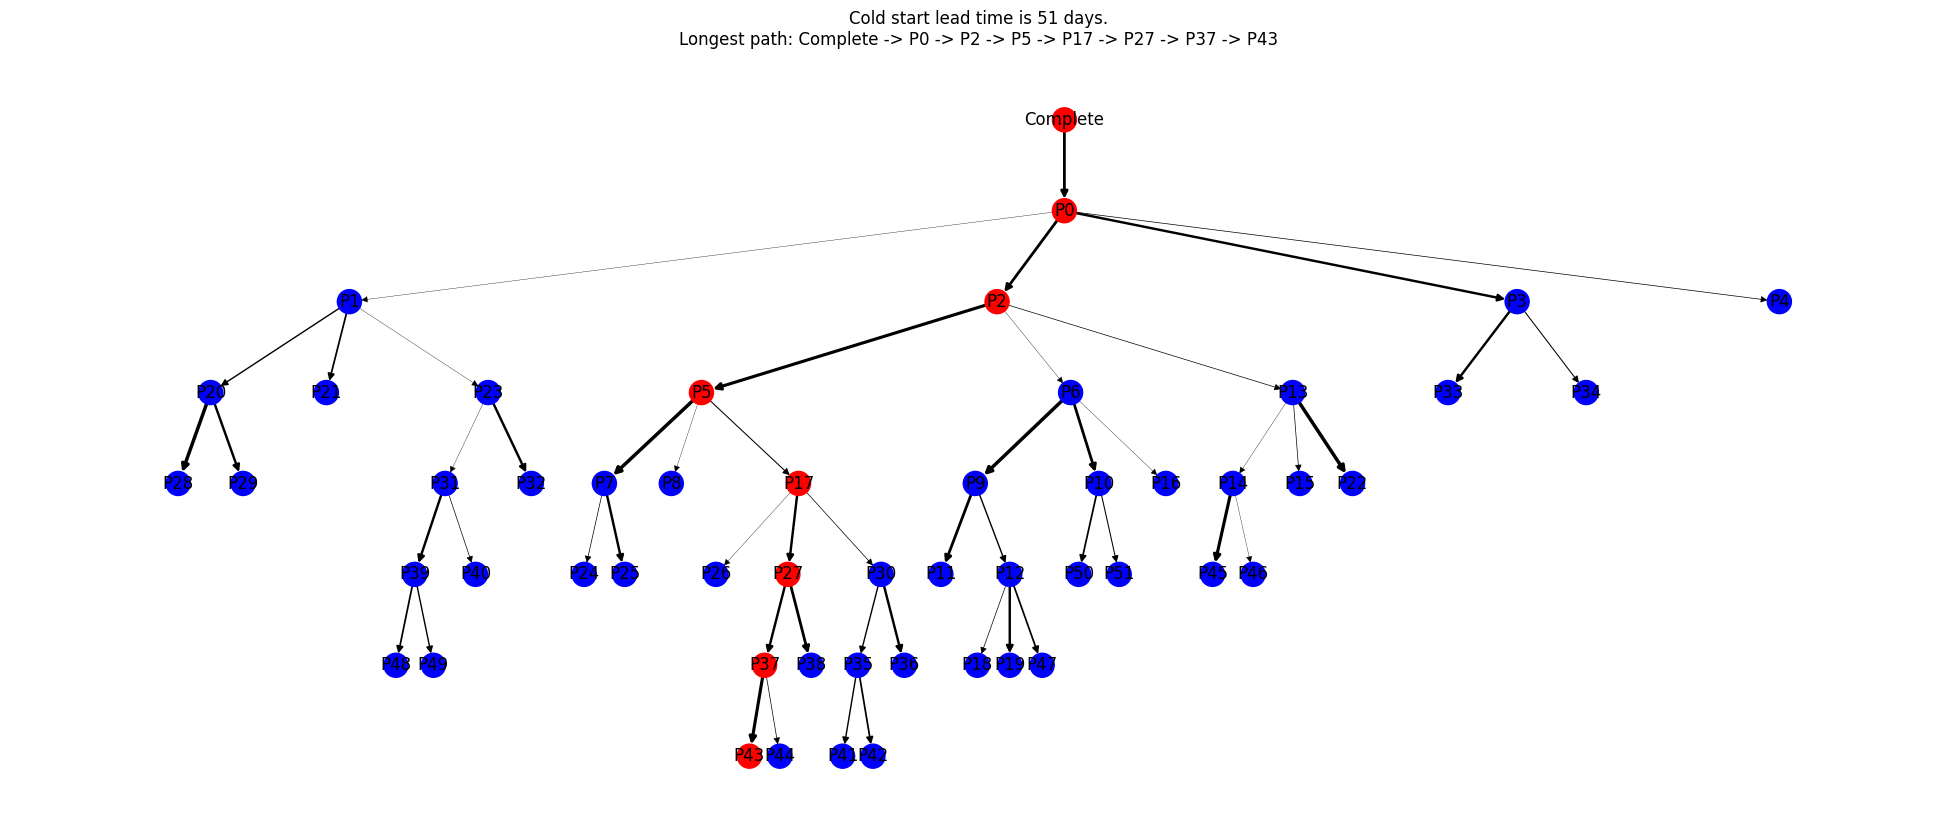

In [109]:
plt.figure(figsize=(25,10))
pos = hierarchy_pos(random_bom,root='Complete')
plt.title(f"Cold start lead time is {longest_path_length} days.\nLongest path: {' -> '.join(longest_path)}")
# plt.text(f"Longest path: {' -> '.join(longest_path[::-1])}")
longest_path_highlight = ['red' if node in longest_path else 'blue' for node in random_bom.nodes]
edge_weights = [random_bom[u][v]['leadtime']/4 for u, v in random_bom.edges]
nx.draw(random_bom, pos=pos, with_labels=True, node_color=longest_path_highlight, width=edge_weights)
plt.show()

In [6]:
list(bom.nodes)

['Part_0',
 'Part_1',
 'Part_2',
 'Part_3',
 'Part_4',
 'Part_5',
 'Part_6',
 'Part_7',
 'Part_8',
 'Part_9']

In [ ]:
def create_random_bom(levels, nodes):
    bom = nx.DiGraph()
    bom.add_node('Part_0')
    
    node = 1
    while node < nodes:
        bom.add_node(f'Part_{node}')
        

        node += 1

In [3]:
test_df = pd.DataFrame([
    {'PARENTPARTNUM':'Complete','PARTNUM': 'A','TYPECODE': 'M','BOMLEVEL':0,'LEADTIME':8},
    {'PARENTPARTNUM':'A','PARTNUM': 'B','TYPECODE': 'M','BOMLEVEL':1,'LEADTIME':10},
    {'PARENTPARTNUM':'A','PARTNUM': 'C','TYPECODE': 'P','BOMLEVEL':1,'LEADTIME':38},
    {'PARENTPARTNUM':'A','PARTNUM': 'D','TYPECODE': 'M','BOMLEVEL':1,'LEADTIME':7},
    {'PARENTPARTNUM':'B','PARTNUM': 'E','TYPECODE': 'M','BOMLEVEL':2,'LEADTIME':9},
    {'PARENTPARTNUM':'B','PARTNUM': 'F','TYPECODE': 'P','BOMLEVEL':2,'LEADTIME':21},
    {'PARENTPARTNUM':'B','PARTNUM': 'G','TYPECODE': 'M','BOMLEVEL':2,'LEADTIME':6},
    {'PARENTPARTNUM':'D','PARTNUM': 'H','TYPECODE': 'P','BOMLEVEL':2,'LEADTIME':23},
    {'PARENTPARTNUM':'D','PARTNUM': 'I','TYPECODE': 'M','BOMLEVEL':2,'LEADTIME':10},
    {'PARENTPARTNUM':'D','PARTNUM': 'J','TYPECODE': 'P','BOMLEVEL':2,'LEADTIME':45},
    {'PARENTPARTNUM':'E','PARTNUM': 'K','TYPECODE': 'P','BOMLEVEL':3,'LEADTIME':25},
    {'PARENTPARTNUM':'E','PARTNUM': 'L','TYPECODE': 'P','BOMLEVEL':3,'LEADTIME':27},
    {'PARENTPARTNUM':'G','PARTNUM': 'M','TYPECODE': 'P','BOMLEVEL':3,'LEADTIME':41},
    {'PARENTPARTNUM':'G','PARTNUM': 'N','TYPECODE': 'P','BOMLEVEL':3,'LEADTIME':35},
    {'PARENTPARTNUM':'I','PARTNUM': 'O','TYPECODE': 'P','BOMLEVEL':3,'LEADTIME':24},
    {'PARENTPARTNUM':'I','PARTNUM': 'P','TYPECODE': 'M','BOMLEVEL':3,'LEADTIME':4},
    {'PARENTPARTNUM':'P','PARTNUM': 'Q','TYPECODE': 'P','BOMLEVEL':4,'LEADTIME':21},
    {'PARENTPARTNUM':'P','PARTNUM': 'R','TYPECODE': 'P','BOMLEVEL':4,'LEADTIME':25},
    {'PARENTPARTNUM':'P','PARTNUM': 'S','TYPECODE': 'P','BOMLEVEL':4,'LEADTIME':29}
])

## Step 2: Create the BomAnalyzer class

In [4]:
class BomAnalyzer:
    def __init__(self):
        """
        Initialize the BOM Analyzer class.
        """
        
        self.bom_df = None
        self.root = None
        self.loaded = False
        self.DG = None
        self.purchased_parts = None
        self.manufactured_parts = None

    def load(self, bom_df: pd.DataFrame, root: str):
        """
        Load the BOM Analyzer with a dataframe containing BOM data.

        Args:
        bom_df: pd.DataFrame
            Expected columns:
            - PARENTPARTNUM
            - PARTNUMTYPECODE
            - BOMLEVEL
            - LEADTIME

        root: str = root part of the BOM
        """

        # re-init values
        self.bom_df = bom_df
        self.root = root
        self.purchased_parts = self.bom_df[self.bom_df['TYPECODE']=='P']['PARTNUM'].drop_duplicates().values
        self.manufactured_parts = self.bom_df[self.bom_df['TYPECODE']=='M']['PARTNUM'].drop_duplicates().values
        self.DG = nx.DiGraph()

        # load graph
        part_nodes = self.bom_df['PARTNUM'].drop_duplicates().to_list()
        for part in part_nodes:
            self.DG.add_node(part)
        
        for _, row in self.bom_df.iterrows():
            parent, child, bom_level, part_type, lead_time = row['PARENTPARTNUM'], row['PARTNUM'], row['BOMLEVEL'], row['TYPECODE'], row['LEADTIME']
            self.DG.add_edge(parent, child, lead_time=lead_time, bom_level=bom_level, part_type=part_type)

        # change loaded state
        self.loaded = True

        print('BOM has been successfully loaded')


    def get_longest_leadtime_path(self):
        """
        Get a dataframe of the longest leadtime sequence.

        Returns:
        - pd.DataFrame
        
        """
        
        if not self.loaded:
            print('BOM not loaded')
            return
            
        longest_path = nx.dag_longest_path(self.DG, weight='lead_time')
        consecutive_pairs = set(zip(longest_path[1:], longest_path))
        longest_path_df = self.bom_df[self.bom_df[['PARTNUM', 'PARENTPARTNUM']].apply(tuple, axis=1).isin(consecutive_pairs)].sort_values(by='BOMLEVEL').drop_duplicates()
        return longest_path_df

    
    def get_longest_leadtime_value(self):
        """
        Get the value of the longest leadtime sequence.

        Returns:
        - float
        """
        if not self.loaded:
            print('BOM not loaded')
            return
            
        return nx.dag_longest_path_length(self.DG, weight='lead_time')


    def get_all_paths(self):
        """
        Get all paths between root part and purchased 
        """
        if not self.loaded:
            print('BOM not loaded')
            return
            
        all_rows = []
        for part in self.purchased_parts:
            paths = nx.all_simple_paths(self.DG,self.root,part)
            for path in paths:
                total_length = 0
                for i in range(len(path)-1):
                    source, target = path[i], path[i+1]
                    edge = self.DG[source][target]
                    length = edge['lead_time']
                    total_length += length
                # print('{}: {}'.format(path, total_length))
                row = {
                    'path': path,
                    'bomlevel': len(path),
                    'leadtime': total_length
                }
            
                all_rows.append(row)
        
        all_paths = pd.DataFrame(all_rows).sort_values(by='leadtime', ascending=False).reset_index(drop=True)
        
        return all_paths


## Step 3: Load the BOM

In [7]:
# init
test_bom = BomAnalyzer()
test_bom.load(test_df, root='A')

BOM has been successfully loaded


## Step 4: Get BOM Insights

### Attributes from the BOM class

In [8]:
# test attributes
print(f'bom_df:\n{test_bom.bom_df}')
print(f'root: {test_bom.root}')
print(f'loaded: {test_bom.loaded}')
print(f'DG: {test_bom.DG}')
print(f'manufactured_parts: {test_bom.manufactured_parts}')
print(f'purchased_parts: {test_bom.purchased_parts}')

bom_df:
   PARENTPARTNUM PARTNUM TYPECODE  BOMLEVEL  LEADTIME
0       Complete       A        M         0         8
1              A       B        M         1        10
2              A       C        P         1        38
3              A       D        M         1         7
4              B       E        M         2         9
5              B       F        P         2        21
6              B       G        M         2         6
7              D       H        P         2        23
8              D       I        M         2        10
9              D       J        P         2        45
10             E       K        P         3        25
11             E       L        P         3        27
12             G       M        P         3        41
13             G       N        P         3        35
14             I       O        P         3        24
15             I       P        M         3         4
16             P       Q        P         4        21
17             P    

### Modules from BOM class

Get all BOM paths from root to purchased part (aka leaf)

In [9]:
test_bom.get_all_paths()

,path,bomlevel,leadtime
0,"[A, B, G, M]",4,57
1,"[A, D, J]",3,52
2,"[A, B, G, N]",4,51
3,"[A, D, I, P, S]",5,50
4,"[A, D, I, P, R]",5,46
5,"[A, B, E, L]",4,46
6,"[A, B, E, K]",4,44
7,"[A, D, I, P, Q]",5,42
8,"[A, D, I, O]",4,41
9,"[A, C]",2,38


Get the longest path. This is effectively where the BOM if bottlenecked during a cold start

In [10]:
test_bom.get_longest_leadtime_path()

,PARENTPARTNUM,PARTNUM,TYPECODE,BOMLEVEL,LEADTIME
0,Complete,A,M,0,8
1,A,B,M,1,10
6,B,G,M,2,6
12,G,M,P,3,41


In [12]:
longest_leadtime_days = test_bom.get_longest_leadtime_value()
print(f'Maximum leadtime is {longest_leadtime_days} days.')

Maximum leadtime is 65 days.
